In [1]:
import torch            		# 导入 torch
import torch.nn as nn     		#  torch的网络组建
import torch.nn.functional as F	#  搭建网络
import torch.optim as optim		# 优化器
import torchvision				# 数据相关
from torchvision import transforms  # 数据处理与增强
import time
import copy
import warnings 
import matplotlib.pyplot as plt 
import numpy as np
from skimage import io
import skimage.transform as tr
plt.style.use('seaborn')
warnings.filterwarnings('ignore')

In [2]:
train_dir = '../data/datasets/train/'
test_dir = '../data/datasets/test/'

In [3]:
train_transform = transforms.Compose([
    transforms.Resize((256,256)),       #  输入尺寸
    transforms.RandomCrop((224,224)),  #  裁剪尺寸
    transforms.RandomHorizontalFlip(p=0.5),  # 随机水平翻转
    transforms.ColorJitter(
        brightness=(0.7,1.3),  # 明暗程度
        contrast=(0.7,1.3),    # 对比度
        saturation=(0.7,1.3),  # 饱和度
        hue=(-0.05,0.05)),     # 颜色
    transforms.ToTensor(),    # 数据转为张量并做归一化
    transforms.Normalize(   # 数据标准化
        mean = [0.485,0.456,0.406],    # RGB均值
        std = [0.229,0.224,0.225])      # RGB 方差  （可以使用经验值（查阅））
])
test_transform = transforms.Compose([
    transforms.Resize((224,224)),   # 输入尺寸（在预测中应遵循此尺寸）
    transforms.ToTensor(),         # 张量      
    transforms.Normalize(         # 标准化
        mean = [0.485,0.456,0.406],
        std = [0.229,0.224,0.225])
])

In [4]:
train_ds = torchvision.datasets.ImageFolder(
    train_dir,    # 导入训练文件夹路径
    transform=train_transform  # 数据处理与增强
)
test_ds = torchvision.datasets.ImageFolder(
    test_dir,     # 导入测试文件夹路径
    transform=test_transform   # 数据处理与增强

)
# 创建dl
BATCHSIZE = 8  # batch_size的批量尺寸
train_dl = torch.utils.data.DataLoader(
    train_ds,   # 将打包好的数据生成可迭代的batch_size个数的批量数据
    batch_size=BATCHSIZE,  # batch_size 值得选择应对照本机配置
    shuffle=True   # 打乱（必须打乱否则模型会识别顺序）
)
test_dl = torch.utils.data.DataLoader(
    test_ds,      
    batch_size=BATCHSIZE
)

In [12]:
#第一层7x7卷积改三层3x3卷积
class RestNetBasicBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride):
        super(RestNetBasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)

    def forward(self, x):
        output = self.conv1(x)
        output = F.relu(self.bn1(output))
        output = self.conv2(output)
        output = self.bn2(output)
        return F.relu(x + output)


class RestNetDownBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride):
        super(RestNetDownBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride[0], padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=stride[1], padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.extra = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride[0], padding=0),
            nn.BatchNorm2d(out_channels)
        )

    def forward(self, x):
        extra_x = self.extra(x)
        output = self.conv1(x)
        out = F.relu(self.bn1(output))

        out = self.conv2(out)
        out = self.bn2(out)
        return F.relu(extra_x + out)


class RestNet18(nn.Module):
    def __init__(self):
        super(RestNet18, self).__init__()
        #self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3)
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=2, padding=3)
        self.conv2 = nn.Conv2d(64, 64, kernel_size=3, padding=3)
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3,padding=3)
        self.bn1 = nn.BatchNorm2d(64)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer1 = nn.Sequential(RestNetBasicBlock(64, 64, 1),
                                    RestNetBasicBlock(64, 64, 1))

        self.layer2 = nn.Sequential(RestNetDownBlock(64, 128, [2, 1]),
                                    RestNetBasicBlock(128, 128, 1))

        self.layer3 = nn.Sequential(RestNetDownBlock(128, 256, [2, 1]),
                                    RestNetBasicBlock(256, 256, 1))

        self.layer4 = nn.Sequential(RestNetDownBlock(256, 512, [2, 1]),
                                    RestNetBasicBlock(512, 512, 1))

        self.avgpool = nn.AdaptiveAvgPool2d(output_size=(1, 1))

        self.fc = nn.Linear(512, 9)

    def forward(self, x):
        out = self.conv1(x)
        out = self.conv2(out)
        out = self.conv3(out)
        out = self.bn1(out)
        out = self.maxpool(out)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.avgpool(out)
        out = out.reshape(x.shape[0], -1)
        out = self.fc(out)
        return out

In [13]:
# model = torchvision.models.resnet18(pretrained=True)
# model = ResNet([2, 2, 2, 2], 9, zero_init_residual= True).to(device)
# model

In [14]:
# # model.features.pool0.kernel_size=2
# #修改为2x2卷积
# #layer1
# model.layer1[0].conv1 = nn.Conv2d(64, 64, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1), bias=False)
# model.layer1[0].conv2 = nn.Conv2d(64, 64, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1), bias=False)
# model.layer1[1].conv1 = nn.Conv2d(64, 64, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1), bias=False)
# model.layer1[1].conv2 = nn.Conv2d(64, 64, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1), bias=False)
# #layer2
# model.layer2[0].conv1 = nn.Conv2d(64, 128, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1), bias=False)
# model.layer2[0].conv2 = nn.Conv2d(128, 128, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1), bias=False)
# model.layer2[1].conv1 = nn.Conv2d(128, 128, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1), bias=False)
# model.layer2[1].conv2 = nn.Conv2d(128, 128, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1), bias=False)
# #layer3
# model.layer3[0].conv1 = nn.Conv2d(128, 256, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1), bias=False)
# model.layer3[0].conv2 = nn.Conv2d(256, 256, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1), bias=False)
# model.layer3[1].conv1 = nn.Conv2d(256, 256, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1), bias=False)
# model.layer3[1].conv2 = nn.Conv2d(256, 256, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1), bias=False)
# #layer4
# model.layer4[0].conv1 = nn.Conv2d(256, 512, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1), bias=False)
# model.layer4[0].conv2 = nn.Conv2d(512, 512, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1), bias=False)
# model.layer4[1].conv1 = nn.Conv2d(512, 512, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1), bias=False)
# model.layer4[1].conv2 = nn.Conv2d(512, 512, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1), bias=False)
# # 冻结 卷积基 操作
# for param in model.parameters():
#     param.requires_grad = False
# # model.fc=nn.Linear(model.fc.in_features,256)
# # model.add_module('fc_relu',nn.ReLU(inplace=True))
# # model.add_module('fc_dp',nn.Dropout(p=0.5, inplace=False))
# # model.add_module('fc1',nn.Linear(256,256))
# # model.add_module('fc1_relu',nn.ReLU(inplace=True))
# # model.add_module('fc1_dp',nn.Dropout(p=0.5, inplace=False))
# # model.add_module('fc2',nn.Linear(256,9))
# # model.add_module('fc1_relu',nn.ReLU(inplace=True))
# # # model.add_module('fc1_dp',nn.Dropout(p=0.5, inplace=False))

# model.fc=nn.Linear(model.fc.in_features,9)
# model

In [15]:
device =torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = RestNet18()
model = model.to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=0.0001)
exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,step_size=20,gamma=0.1)

In [16]:
# 搭建训练步骤
def train(dataloader,model,loss_fn,optimizer):
    # acc 当前样本一共有多少个
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    # 初始化loss值
    train_loss,correct = 0,0
    model.train()  # 模式为训练模式
    for X,y in dataloader:
        # 前向传播（推理）
        X,y = X.to(device),y.to(device)
        pred = model(X)
        # 产生误差
        loss = loss_fn(pred,y)  # 返回平均误差
        # loss = torch.nn.functional.cross_entropy(pred, y)
        # 归零权重(固定写法)
        optimizer.zero_grad()
        # 反向传递
        loss.backward()
        # 利用梯度下降优化参数
        optimizer.step()
        # # 放弃张量微分的追踪（小验证）
        with torch.no_grad():
            train_loss += loss.item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    exp_lr_scheduler.step()
    lr_res = optimizer.state_dict()['param_groups'][0]['lr']
    correct /= size        
    train_loss /= num_batches
    return train_loss,correct,lr_res

In [17]:
# 搭建测试 （test）
def test(dataloader,model):
    # acc 当前样本一共有多少个
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss,correct = 0,0
    model.eval()  # 推理模式
    with torch.no_grad():
        for X,y in dataloader:
            X,y = X.to(device),y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred,y)
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    correct /= size        
    test_loss /= num_batches
    return test_loss,correct

In [18]:
best_model_wts = copy.deepcopy(model.state_dict()) # 用以记录模型最优参数
best_acc = 0.0
epochs = 50
train_acc = []
train_loss = []
test_acc = []
test_loss = []
for epoch in range(epochs):
    start  =  time.time()
    epoch_loss,epoch_acc,lr = train(dataloader=train_dl,model=model,loss_fn=loss_fn,optimizer=optimizer)
    epoch_test_loss,epoch_test_acc = test(dataloader=test_dl,model=model)
    end = time.time()
    times = end - start 
    train_acc.append(epoch_acc)
    train_loss.append(epoch_loss)
    test_acc.append(epoch_test_acc)
    test_loss.append(epoch_test_loss)
    print('训练epoch{},训练集损失值:{:.2f},训练集的准确率:{:.2f}%,测试集损失值:{:.2f},测试集的准确率:{:.2f}%,当前学习率:{},消耗时间：{:.2f}s'.
          format(epoch+1,epoch_loss,epoch_acc*100,epoch_test_loss,epoch_test_acc*100,lr,times))
    # 保存best——model
    if epoch_test_acc > best_acc:  # 如果当前的test_acc 高于best_acc 执行保存
        best_acc = epoch_test_acc
        best_model_wts = copy.deepcopy(model.state_dict())
print('训练结束并保存最好权重模型')

训练epoch1,训练集损失值:1.67,训练集的准确率:39.89%,测试集损失值:1.03,测试集的准确率:63.73%,当前学习率:0.0001,消耗时间：355.64s
训练epoch2,训练集损失值:1.04,训练集的准确率:63.93%,测试集损失值:0.72,测试集的准确率:74.62%,当前学习率:0.0001,消耗时间：361.93s
训练epoch3,训练集损失值:0.73,训练集的准确率:75.07%,测试集损失值:0.52,测试集的准确率:81.69%,当前学习率:0.0001,消耗时间：365.39s
训练epoch4,训练集损失值:0.53,训练集的准确率:81.73%,测试集损失值:0.34,测试集的准确率:88.33%,当前学习率:0.0001,消耗时间：368.46s
训练epoch5,训练集损失值:0.41,训练集的准确率:86.42%,测试集损失值:0.34,测试集的准确率:88.03%,当前学习率:0.0001,消耗时间：369.16s
训练epoch6,训练集损失值:0.32,训练集的准确率:89.35%,测试集损失值:0.42,测试集的准确率:85.08%,当前学习率:0.0001,消耗时间：370.61s
训练epoch7,训练集损失值:0.26,训练集的准确率:91.60%,测试集损失值:0.23,测试集的准确率:92.49%,当前学习率:0.0001,消耗时间：371.25s
训练epoch8,训练集损失值:0.23,训练集的准确率:92.42%,测试集损失值:0.16,测试集的准确率:94.62%,当前学习率:0.0001,消耗时间：375.95s
训练epoch9,训练集损失值:0.18,训练集的准确率:94.07%,测试集损失值:0.20,测试集的准确率:93.54%,当前学习率:0.0001,消耗时间：371.73s
训练epoch10,训练集损失值:0.16,训练集的准确率:94.56%,测试集损失值:0.22,测试集的准确率:92.84%,当前学习率:0.0001,消耗时间：370.90s
训练epoch11,训练集损失值:0.15,训练集的准确率:94.87%,测试集损失值:0.13,测试集的准确率:96.14%,当前学习率:0.0001,消耗时间：371.12s
训练epoch12,训练集损失值:0.

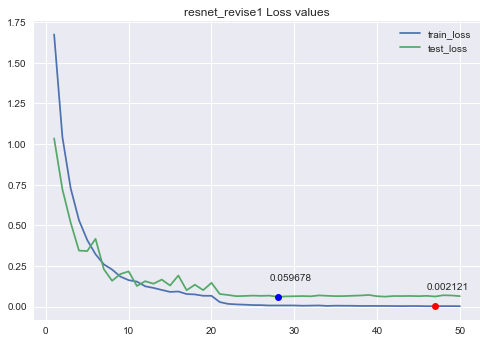

In [25]:
## 训练曲线可视化
# 损失值
train_loss_min_index = np.argmin(np.array(train_loss))
train_loss_min_value = round(train_loss[train_loss_min_index],6)
# test_loss = torch.stack(test_loss).cpu().numpy()
test_loss_min_index = np.argmin(test_loss)
test_loss_min_value = round(test_loss[test_loss_min_index],6)

s = train_loss_min_value
s_test = test_loss_min_value
plt.plot(range(1,51),train_loss,label='train_loss')
plt.plot(range(1,51),test_loss,label='test_loss')
plt.text(train_loss_min_index, train_loss_min_value+0.1, s)
plt.text(test_loss_min_index, test_loss_min_value+0.1, s_test)
plt.plot(train_loss_min_index+1,train_loss_min_value,'ro')
plt.plot(test_loss_min_index+1,test_loss_min_value,'bo')
plt.title('resnet_revise1 Loss values')
plt.legend()

plt.savefig('../resnet1/resnet_revise1_loss')

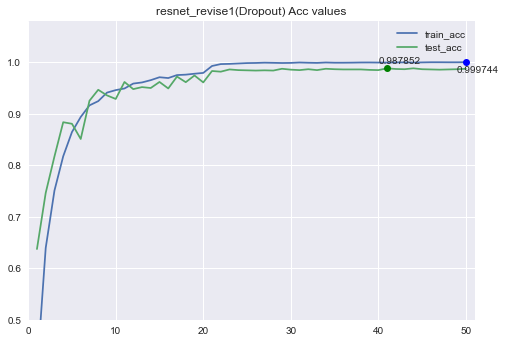

In [26]:
## 训练曲线可视化
# 准确率
train_acc_max_index = np.argmax(np.array(train_acc))
train_acc_max_value = round(train_acc[train_acc_max_index],6)
test_acc_max_index = np.argmax(np.array(test_acc))
test_acc_max_value = round(test_acc[test_acc_max_index],6)

s = train_acc_max_value
s_test = test_acc_max_value
plt.plot(range(1,epoch+2),train_acc,label='train_acc')
plt.plot(range(1,epoch+2),test_acc,label='test_acc')
plt.text(train_acc_max_index, train_acc_max_value-0.02, s)
plt.text(test_acc_max_index, test_acc_max_value+0.01, s_test)
plt.plot(train_acc_max_index+1,train_acc_max_value,'bo')
plt.plot(test_acc_max_index+1,test_acc_max_value,'go')
plt.title('resnet_revise1(Dropout) Acc values')
plt.ylim(0.5,1.08)
plt.xlim(0,51)
plt.legend()
plt.savefig('../resnet1/resnet_revise1_acc')

In [23]:
torch.save(model.state_dict(),'resnet_revise2.pth')